In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding
from tensorflow.keras.metrics import Precision, Recall, AUC




In [2]:
data = pd.read_csv('airline_sentiment_analysis.csv', index_col=0)
data.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [4]:
# Mapping sentiment values to numerical values
data['sentiment'] = data['airline_sentiment'].map({'positive':1, 'negative':0})

In [5]:
data.head()

,airline_sentiment,text,sentiment
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [6]:
# Tokenizing the text 
token = Tokenizer()
token.fit_on_texts(data['text'])
tokenized_text = token.texts_to_sequences(data['text'])

# Padding the tokenized text so that they are all the same lengths
# finding the length of the longest text to set as max length of padding
longest = max(len(l) for l in tokenized_text) 
padded_tokenized_text = pad_sequences(tokenized_text, maxlen=longest).tolist()

In [7]:
# Adding tokenized text to the df
data['tokenized_text'] = padded_tokenized_text
data.head()

,airline_sentiment,text,sentiment,tokenized_text
1,positive,@VirginAmerica plus you've added commercials t...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,negative,@VirginAmerica it's really aggressive to blast...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,negative,@VirginAmerica and it's a really big bad thing...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 3..."
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# Splitting into training and testing data
training_data = data.sample(frac=0.8, random_state=1)
testing_data = data.drop(training_data.index)

In [9]:
# Creating tf model
model = Sequential()
model.add(Embedding(input_dim = len(token.word_index)+1,
                    output_dim = 32,
                    input_length=longest))
# drop out layer to help with overfitting
model.add(SpatialDropout1D(0.25))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[Precision(), Recall(), AUC()])
print(model.summary())

2022-07-15 23:53:34.192541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 32)            423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 36, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 36, 100)           53200     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 36, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0

In [10]:
# training the model
hist = model.fit(np.array(training_data['tokenized_text'].values.tolist()), training_data['sentiment'],
                    validation_split=0.2, epochs=5, batch_size=50)

Epoch 1/5
148/148 [==============================] - 55s 235ms/step - loss: 0.4249 - precision: 0.6404 - recall: 0.2612 - auc: 0.7674 - val_loss: 0.3018 - val_precision: 0.7556 - val_recall: 0.6152 - val_auc: 0.9075
Epoch 2/5
148/148 [==============================] - 30s 202ms/step - loss: 0.2402 - precision: 0.7936 - recall: 0.7160 - auc: 0.9397 - val_loss: 0.2440 - val_precision: 0.8431 - val_recall: 0.6754 - val_auc: 0.9420
Epoch 3/5
148/148 [==============================] - 24s 162ms/step - loss: 0.1671 - precision: 0.8611 - recall: 0.7971 - auc: 0.9716 - val_loss: 0.2328 - val_precision: 0.8497 - val_recall: 0.7251 - val_auc: 0.9498
Epoch 4/5
148/148 [==============================] - 24s 163ms/step - loss: 0.1229 - precision: 0.8982 - recall: 0.8747 - auc: 0.9835 - val_loss: 0.2489 - val_precision: 0.8590 - val_recall: 0.7016 - val_auc: 0.9471
Epoch 5/5
148/148 [==============================] - 27s 181ms/step - loss: 0.0984 - precision: 0.9230 - recall: 0.8995 - auc: 0.9893 - 

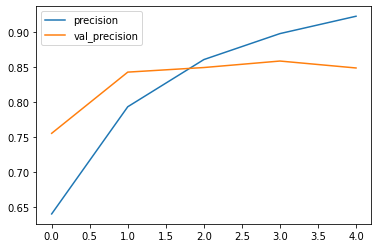

In [11]:
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.legend()
plt.show()

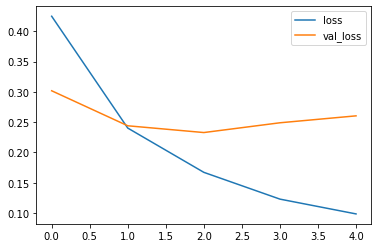

In [12]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
def pred(text):
    # tokenize the input text
    tokenized_text = token.texts_to_sequences([text])
    padded_tokenized_text = pad_sequences(tokenized_text, maxlen=longest)

    # predict with model - will give float between 0 and 1
    pred_int = model.predict(padded_tokenized_text).round().item()

    # Return positve if 1, negative if 0
    pred_dict = {1:'Positive', 0:'Negative'}
    return pred_dict[pred_int]


In [23]:
print(pred('What an awful show'))
print(pred('What a great show'))

1/1 [==============================] - 0s 203ms/step
Negative
1/1 [==============================] - 0s 87ms/step
Positive
